In [1]:
# install for AWS
!pip install torch --quiet
!pip install matplotlib --quiet
!pip install torchvision --quiet
!pip install s3fs --quiet
!pip install boto3 --quiet
!pip install fiftyone --quiet
!pip install pandas --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.28.68 requires botocore<1.32.0,>=1.31.68, but you have botocore 1.31.64 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.7.0 requires botocore<1.31.65,>=1.31.16, but you have botocore 1.31.74 which is incompatible.


In [80]:
import torch
import torchvision
from torch.utils.data import DataLoader
import json
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet34
import numpy as np
import boto3
import s3fs
import matplotlib.pyplot as plt
import pandas as pd
import os

import fiftyone.utils.torch as fout
import fiftyone as fo
import fiftyone.brain as fob
import fiftyone.zoo as foz
from fiftyone import ViewField as F
import fiftyone.core.expressions as foe

from models_package import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
# ########## LM ##########

# access_key = getpass.getpass("Enter your access: ")

# secret_key = password = getpass.getpass("Enter your secret: ")

# bucket_name = 'w210facetdata'
# annotations_prefix = 'annotations/'
# images_prefix = '/home/ubuntu/W210-Capstone'

# s3 = s3fs.S3FileSystem(key=access_key, secret=secret_key)

# # Use s3.open to open the CSV file and read its content into a Pandas DataFrame
# with s3.open(f's3://{bucket_name}/{annotations_prefix}annotations.csv', 'rb') as file:
#     gt_df = pd.read_csv(file)



In [4]:
# ########## LM ##########

# # use relative paths to your image dirs
# dataset = fo.Dataset(name = "IDP", persistent=True)
# # dataset = fo.load_dataset('IDP')
# dataset.add_images_dir(images_prefix)
# dataset.compute_metadata()

In [5]:
########## KH ##########

# Initialize S3 client
s3_client = boto3.client('s3', region_name='us-west-2')

# Define the S3 bucket name and prefixes
bucket_name = 'w210facetdata'
annotations_prefix = 'annotations/'
images_prefix = 'images/'

# Load CSV annotations from S3
annotations_s3_path = f's3://{bucket_name}/{annotations_prefix}'
gt_df = pd.read_csv(f'{annotations_s3_path}annotations.csv')

In [6]:
# ########## KH ##########

# UNCOMMENT THIS BLOCK TO PULL FACET DATA FROM S3

# local_images_dir = 'local_images_dir'
# os.makedirs(local_images_dir, exist_ok=True)

# # Create a paginator to handle pagination of the results
# paginator = s3_client.get_paginator('list_objects_v2')

# # Use the paginator to retrieve all objects
# for page in paginator.paginate(Bucket=bucket_name, Prefix=images_prefix):
#     for obj in page.get('Contents', []):
#         # Skip the prefix itself
#         if obj['Key'] == images_prefix:
#             continue
#         local_file_path = os.path.join(local_images_dir, os.path.basename(obj['Key']))
#         s3_client.download_file(bucket_name, obj['Key'], local_file_path)


In [7]:
########## KH ##########
local_images_dir = 'local_images_dir'
fo.delete_dataset('local_images_dir')
dataset = fo.Dataset(name='local_images_dir', persistent=True)
dataset.add_images_dir(local_images_dir)
dataset.compute_metadata()

 100% |█████████████| 31703/31703 [4.7s elapsed, 0s remaining, 6.9K samples/s]      
Computing metadata...
 100% |█████████████| 31703/31703 [1.0m elapsed, 0s remaining, 610.5 samples/s]       


In [8]:
# Count the number of files in the local_images_dir
num_files = len([f for f in os.listdir(local_images_dir) if os.path.isfile(os.path.join(local_images_dir, f))])
print(num_files)

31702


# Object Detection Functions

In [9]:
BOOLEAN_PERSONAL_ATTRS = (
    "has_facial_hair",
    "has_tattoo",
    "has_cap",
    "has_mask",
    "has_headscarf",
    "has_eyeware",
)
def add_boolean_person_attributes(detection, row_index):
    for attr in BOOLEAN_PERSONAL_ATTRS:
        detection[attr] = gt_df.loc[row_index, attr].astype(bool)

In [10]:
def get_hairtype(row_index):
    hair_info = gt_df.loc[row_index, gt_df.columns.str.startswith('hairtype')]
    hairtype = hair_info[hair_info == 1]
    if len(hairtype) == 0:
        return None
    return hairtype.index[0].split('_')[1]

def get_haircolor(row_index):
    hair_info = gt_df.loc[row_index, gt_df.columns.str.startswith('hair_color')]
    haircolor = hair_info[hair_info == 1]
    if len(haircolor) == 0:
        return None
    return haircolor.index[0].split('_')[2]

In [11]:
def add_person_attributes(detection, row_index):
    detection["hairtype"] = get_hairtype(row_index)
    detection["haircolor"] = get_haircolor(row_index)
    add_boolean_person_attributes(detection, row_index)

In [12]:
def get_perceived_gender_presentation(row_index):
    gender_info = gt_df.loc[row_index, gt_df.columns.str.startswith('gender')]
    pgp = gender_info[gender_info == 1]
    if len(pgp) == 0:
        return None
    return pgp.index[0].replace("gender_presentation_", "").replace("_", " ")

def get_perceived_age_presentation(row_index):
    age_info = gt_df.loc[row_index, gt_df.columns.str.startswith('age')]
    pap = age_info[age_info == 1]
    if len(pap) == 0:
        return None
    return pap.index[0].split('_')[2]

In [13]:
def get_skintone(row_index):
    skin_info = gt_df.loc[row_index, gt_df.columns.str.startswith('skin_tone')]
    return skin_info.to_dict()

In [14]:
def add_protected_attributes(detection, row_index):
    detection["perceived_age_presentation"] = get_perceived_age_presentation(row_index)
    detection["perceived_gender_presentation"] = get_perceived_gender_presentation(row_index)
    detection["skin_tone"] = get_skintone(row_index)

In [15]:
VISIBILITY_ATTRS = ("visible_torso", "visible_face", "visible_minimal")

In [16]:
def get_lighting(row_index):
    lighting_info = gt_df.loc[row_index, gt_df.columns.str.startswith('lighting')]
    lighting = lighting_info[lighting_info == 1]
    if len(lighting) == 0:
        return None
    lighting = lighting.index[0].replace("lighting_", "").replace("_", " ")
    return lighting

def add_other_attributes(detection, row_index):
    detection["lighting"] = get_lighting(row_index)
    for attr in VISIBILITY_ATTRS:
        detection[attr] = gt_df.loc[row_index, attr].astype(bool)

In [17]:
def create_detection(row_index, sample):
    bbox_dict = json.loads(gt_df.loc[row_index, "bounding_box"])
    x, y, w, h = bbox_dict["x"], bbox_dict["y"], bbox_dict["width"], bbox_dict["height"]
    cat1, cat2 = bbox_dict["dict_attributes"]["cat1"], bbox_dict["dict_attributes"]["cat2"]

    person_id = gt_df.loc[row_index, "person_id"]

    img_width, img_height = sample.metadata.width, sample.metadata.height

    bounding_box = [x/img_width, y/img_height, w/img_width, h/img_height]
    detection = fo.Detection(
        label=cat1, 
        bounding_box=bounding_box,
        person_id=person_id,
        )

    detection["class2"] = cat2

    add_person_attributes(detection, row_index)
    add_protected_attributes(detection, row_index)
    add_other_attributes(detection, row_index)

    return detection

In [18]:
def add_ground_truth_labels(dataset):
    for sample in dataset.iter_samples(autosave=True, progress=True):
        sample_annos = gt_df[gt_df['filename'] == sample.filename]
        detections = []
        for row in sample_annos.iterrows():
            row_index = row[0]
            detection = create_detection(row_index, sample)
            detections.append(detection)
        sample["ground_truth"] = fo.Detections(detections=detections)
    dataset.add_dynamic_sample_fields()



# Add labels

In [19]:
## add all of the ground truth labels
add_ground_truth_labels(dataset)

 100% |█████████████| 31703/31703 [5.8m elapsed, 0s remaining, 89.1 samples/s]      


# Student and Teacher Disparity Evaluation Pipeline

In [52]:
# dataset = fo.load_dataset('IDP')
# fo.list_datasets()
# dataset = fo.load_dataset('local_images_dir')


In [53]:
reversed_mapping = {
    'bartender': 'Chef',
    'doctor': 'Doctor',
    'carpenter': 'Engineer',
    'computer_user': 'Engineer',
    'electrician': 'Engineer',
    'farmer': 'Farmer',
    'gardener': 'Farmer',
    'fireman': 'Firefighter',
    'judge': 'Judge',
    'laborer': 'Mechanic',
    'machinist': 'Mechanic',
    'astronaut': 'Pilot',
    'lawman': 'Police',
    'guard': 'Police',
    'waiter': 'Waiter',
    'soldier': 'Police'
}

In [81]:
def update_label(detections):
    for detection in detections.detections:
        detection.label = reversed_mapping.get(detection.label, detection.label)
        if detection.class2:
            detection.class2 = reversed_mapping.get(detection.class2, detection.class2)
    return detections

def compute_weighted_avg_skin_tone(detections):
    for detection in detections.detections:
        skin_tone_dict = detection.skin_tone
        total_counts = sum(value for key, value in skin_tone_dict.items() if key != 'skin_tone_na')
        if total_counts == 0:
            detection['light_skin_indicator'] = 0
            continue
        weighted_avg_skin_tone = sum(int(key.split('_')[-1]) * value for key, value in skin_tone_dict.items() if key != 'skin_tone_na') / total_counts
        detection['light_skin_indicator'] = False if weighted_avg_skin_tone > 5.5 else True

# Iterate through the dataset and update the labels
for sample in dataset:
    sample['ground_truth'] = update_label(sample['ground_truth'])  
    compute_weighted_avg_skin_tone(sample['ground_truth'])
    sample.save()


In [127]:
# Load the student model architecture and weights
# student_model = StudentModel(in_features=16, num_classes=10)

# TEACHER
student_model = resnet34(weights=None)
weights_path = 'teacher_model_weights_ckd_prof.pth'

# STUDENT
student_model = resnet18(weights=None)
weights_path = 'student_model_weights_ckd_prof.pth'

# teacher_model = TeacherModel(in_features=16, num_classes=10)

# weights_path = 'student_model_weights_ckd_1.pth'
# teacher_weights_path = 'teacher_model_weights3.pth'

student_model.load_state_dict(torch.load(weights_path))
# teacher_model.load_state_dict(torch.load(teacher_weights_path))

<All keys matched successfully>

In [128]:
def make_data_loader(image_paths, sample_ids, batch_size):
    mean = [0.5071, 0.4867, 0.4408]
    std = [0.2675, 0.2565, 0.2761]
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((256, 256)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean, std),
        ]
    )
    dataset = fout.TorchImageDataset(
        image_paths, sample_ids=sample_ids, transform=transforms
    )
    return DataLoader(dataset, batch_size=batch_size, num_workers=4)

model = student_model.to(device)


In [129]:
def predict(model, imgs):
    logits = model(imgs).detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)
    odds = np.exp(logits)
    confidences = np.max(odds, axis=1) / np.sum(odds, axis=1)
    return predictions, confidences

In [130]:
batch_size = 32

view = dataset.match({"ground_truth.detections.label": {"$in": ['Police', 'Mechanic', 'Pilot', 'Firefighter', 'Doctor',
       'Farmer', 'Engineer', 'Waiter', 'Judge', 'Chef']}})

image_paths, sample_ids = zip(*[(s.filepath, s.id) for s in view])
data_loader = make_data_loader(image_paths, sample_ids, batch_size)


In [131]:
counter = 0
for i in view.iter_samples():
    print(i.ground_truth.detections)
    counter += 1
    if counter >= 10:
        break


[<Detection: {
    'id': '654066f9ee841d1341459f36',
    'attributes': {},
    'tags': [],
    'label': 'Mechanic',
    'bounding_box': [
        0.5629111111111111,
        0.30590666666666666,
        0.17054222222222223,
        0.6171733333333334,
    ],
    'mask': None,
    'confidence': None,
    'index': None,
    'person_id': 509933224511290,
    'class2': 'none',
    'hairtype': 'wavy',
    'haircolor': 'grey',
    'has_facial_hair': False,
    'has_tattoo': False,
    'has_cap': False,
    'has_mask': False,
    'has_headscarf': False,
    'has_eyeware': False,
    'perceived_age_presentation': 'na',
    'perceived_gender_presentation': 'masc',
    'skin_tone': {
        'skin_tone_1': 0,
        'skin_tone_2': 2,
        'skin_tone_3': 3,
        'skin_tone_4': 2,
        'skin_tone_5': 0,
        'skin_tone_6': 0,
        'skin_tone_7': 0,
        'skin_tone_8': 0,
        'skin_tone_9': 0,
        'skin_tone_10': 0,
        'skin_tone_na': 0,
    },
    'lighting': 'well 

In [132]:
classes = {
    "9" : "Waiter",
    "6" : "Mechanic",
    "2" : "Engineer",
    "4" : "Firefighter",
    "0" : "Chef",
    "5" : "Judge",
    "7" : "Pilot",
    "8" : "Police",
    "3" : "Farmer",
    "1" : "Doctor"
}

In [133]:
# Perform prediction and store results in dataset

for imgs, sample_ids in data_loader:
    imgs = imgs.to(device)
    predictions, confidences = predict(model, imgs)

    # Add predictions to your FiftyOne dataset
    for sample_id, prediction, confidence in zip(
        sample_ids, predictions, confidences
    ):
        sample = view[sample_id]
        sample["pred"] = fo.Classification(
            label=classes[str(prediction)],  # Use the mapping to get class labels
            confidence=confidence,
        )
        sample.save()

In [134]:
def _evaluate_classification_modelr(dataset, prediction_field):
    eval_key = "eval_" + prediction_field
    
    for sample in dataset.iter_samples(progress=True):
        labels = []

        # Iterate through the detections and extract the "label" field
        for detection in sample.ground_truth.detections:
            label = detection.label
            label2 = detection.class2
            if label is not None:  # Check if "label" exists in the dictionary
                labels.append(label)
            if label2 is not None: 
                labels.append(label2)
                
        if sample[prediction_field].label in labels:
            sample[eval_key] = True
        else:
            sample[eval_key] = False
        sample.save()


In [135]:
_evaluate_classification_modelr(view, 'pred')

 100% |█████████████| 10510/10510 [26.2s elapsed, 0s remaining, 397.3 samples/s]      


In [136]:
def _compute_classification_recall(patch_collection, label_field):
    eval_key = "eval_" + label_field
    counts = patch_collection.count_values(eval_key)
    tp, fn = counts.get(True, 0), counts.get(False, 0)
    recall = tp/float(tp + fn) if tp > 0 else 1e-6
    return recall

In [137]:
def _compute_classification_results(patch_collection, label_field):
    eval_key = "eval_" + label_field
    counts = patch_collection.count_values(eval_key)
    tp, fn = counts.get(True, 0), counts.get(False, 0)
    recall = tp/float(tp + fn) if tp > 0 else 1e-6
    return counts

In [138]:
def get_concept_attr_classification_recall(dataset, label_field, concept, attributes):
    sub_patch_view_primary = dataset.filter_labels("ground_truth", F("label") == concept)
    for attribute in attributes.items():
        if "skin_tone" in attribute[0]:
            sub_patch_view_primary = sub_patch_view_primary.filter_labels('ground_truth', F(f"skin_tone.{attribute[0]}") != 0)
        else:
            sub_patch_view_primary = sub_patch_view_primary.filter_labels('ground_truth', F(f"{attribute[0]}") == attribute[1])
    primary = _compute_classification_recall(sub_patch_view_primary, label_field)
    return primary

In [139]:
def compute_disparity(dataset, label_field, concept, attribute1, attribute2):
    recall1 = get_concept_attr_classification_recall(dataset, label_field, concept, attribute1)
    recall2 = get_concept_attr_classification_recall(dataset, label_field, concept, attribute2)
    return (recall1 - recall2)

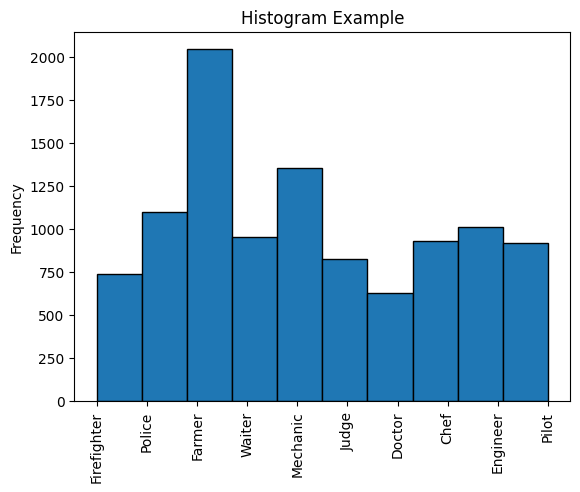

In [140]:
preds = []
for i in view.iter_samples(): 
    preds.append(i.pred.label)  

# Create a histogram
plt.hist(preds, bins=10, edgecolor='k')  # 'bins' determines the number of bins or bars

# Add labels and a title
plt.ylabel('Frequency')
plt.title('Histogram Example')

# Rotate x-axis labels to vertical
plt.xticks(rotation='vertical')

# Show the histogram
plt.show()

In [141]:
concepts = ['Police', 'Mechanic', 'Pilot', 'Firefighter', 'Doctor',
       'Farmer', 'Engineer', 'Waiter', 'Judge', 'Chef']

for i in concepts: 
    print(f'{i}:{_compute_classification_recall(view.filter_labels("ground_truth", F("label") == i), "pred")}')

Police:0.2210809488872585
Mechanic:0.228328611898017
Pilot:0.12254901960784313
Firefighter:0.3346613545816733
Doctor:0.3568
Farmer:0.8085676037483266
Engineer:0.0806861499364676
Waiter:0.3074074074074074
Judge:0.22916666666666666
Chef:0.25


In [142]:
# desired attribute list for disparity calcs
attributes = {
    'hairtype': ['straight', 'curly', 'bald', 'wavy', 'dreadlocks', 'coily'],
    'haircolor': ['black', 'blonde', 'red', 'colored', 'brown', 'grey'],
    'perceived_age_presentation': ['young', 'middle', 'older'],
    'perceived_gender_presentation': ['fem', 'masc', 'non binary'],
    'has_facial_hair': [False, True],
    'has_tattoo': [False, True],
    'has_cap': [False, True],
    'has_mask': [False, True],
    'has_headscarf': [False, True],
    'has_eyeware': [False, True],
    'light_skin_indicator': [False, True], # 0 is light, 1 is dark
}


In [143]:
# Dictionary to store cumulative disparity and count for each attribute / concept combo
disparity_dict = {}

# Iterate through each concept
for concept in concepts:
    # Iterate through each attribute
    for attribute_name, attribute_values in attributes.items():
        total_disparity = 0
        count = 0
        # Iterate through each pair of attribute values
        for i in range(len(attribute_values)):
            for j in range(i + 1, len(attribute_values)):
                attribute1 = {attribute_name: attribute_values[i]}
                attribute2 = {attribute_name: attribute_values[j]}
                # Compute disparity
                disparity = compute_disparity(view, 'pred', concept, attribute1, attribute2)
                total_disparity += abs(disparity)
                count += 1
        # Update the dictionary with the average disparity for this attribute within this concept
        key = (concept, attribute_name)
        average_disparity = total_disparity / count if count > 0 else 0
        disparity_dict[key] = average_disparity

# Output the average disparity for each attribute within each concept
for key, average_disparity in disparity_dict.items():
    concept, attribute_name = key
    print(f'Average disparity for {attribute_name} in concept {concept}: {average_disparity:.4f}')


Average disparity for hairtype in concept Police: 0.1469
Average disparity for haircolor in concept Police: 0.0437
Average disparity for perceived_age_presentation in concept Police: 0.0336
Average disparity for perceived_gender_presentation in concept Police: 0.0966
Average disparity for has_facial_hair in concept Police: 0.0190
Average disparity for has_tattoo in concept Police: 0.1288
Average disparity for has_cap in concept Police: 0.0116
Average disparity for has_mask in concept Police: 0.0219
Average disparity for has_headscarf in concept Police: 0.0402
Average disparity for has_eyeware in concept Police: 0.0606
Average disparity for light_skin_indicator in concept Police: 0.0180
Average disparity for hairtype in concept Mechanic: 0.1257
Average disparity for haircolor in concept Mechanic: 0.0473
Average disparity for perceived_age_presentation in concept Mechanic: 0.0107
Average disparity for perceived_gender_presentation in concept Mechanic: 0.1660
Average disparity for has_fac

In [144]:
# Dictionary to store cumulative disparity and count for each concept
concept_disparity_dict = {}

# Iterate through each concept
for concept in concepts:
    total_disparity = 0
    count = 0
    # Iterate through each attribute
    for attribute_name, attribute_values in attributes.items():
        # Iterate through each pair of attribute values
        for i in range(len(attribute_values)):
            for j in range(i + 1, len(attribute_values)):
                attribute1 = {attribute_name: attribute_values[i]}
                attribute2 = {attribute_name: attribute_values[j]}
                # Compute disparity
                disparity = compute_disparity(view, 'pred', concept, attribute1, attribute2)
                total_disparity += abs(disparity)
                count += 1
    # Update the dictionary with the average disparity for this concept
    average_disparity = total_disparity / count if count > 0 else 0
    concept_disparity_dict[concept] = average_disparity

# Output the average disparity for each concept
for concept, average_disparity in concept_disparity_dict.items():
    print(f'Average disparity in concept {concept}: {average_disparity:.4f}')


Average disparity in concept Police: 0.0826
Average disparity in concept Mechanic: 0.0780
Average disparity in concept Pilot: 0.1786
Average disparity in concept Firefighter: 0.2556
Average disparity in concept Doctor: 0.2573
Average disparity in concept Farmer: 0.1161
Average disparity in concept Engineer: 0.0806
Average disparity in concept Waiter: 0.2358
Average disparity in concept Judge: 0.2395
Average disparity in concept Chef: 0.3662


In [145]:
# calcluate overall model disparity
mean_disparity = round(np.mean(list(concept_disparity_dict.values())), 4)
print(f'Overall average disparity across concepts: {mean_disparity:.4f}')

Overall average disparity across concepts: 0.1890


In [146]:
# Dictionary to store cumulative disparity and count for each attribute
attribute_disparity_dict = {}

# Iterate through each attribute
for attribute_name, attribute_values in attributes.items():
    total_disparity = 0
    count = 0
    # Iterate through each concept
    for concept in concepts:
        # Iterate through each pair of attribute values
        for i in range(len(attribute_values)):
            for j in range(i + 1, len(attribute_values)):
                attribute1 = {attribute_name: attribute_values[i]}
                attribute2 = {attribute_name: attribute_values[j]}
                # Compute disparity
                disparity = compute_disparity(view, 'pred', concept, attribute1, attribute2)
                total_disparity += abs(disparity)
                count += 1
    # Update the dictionary with the average disparity for this attribute
    average_disparity = total_disparity / count if count > 0 else 0
    attribute_disparity_dict[attribute_name] = average_disparity

# Output the average disparity for each attribute
for attribute_name, average_disparity in attribute_disparity_dict.items():
    print(f'Average disparity in attribute {attribute_name}: {average_disparity:.4f}')

# Calculate overall model disparity
mean_disparity_attribute = round(np.mean(list(attribute_disparity_dict.values())), 4)
print(f'Overall average disparity across attributes: {mean_disparity_attribute:.4f}')


Average disparity in attribute hairtype: 0.2546
Average disparity in attribute haircolor: 0.1812
Average disparity in attribute perceived_age_presentation: 0.1177
Average disparity in attribute perceived_gender_presentation: 0.1581
Average disparity in attribute has_facial_hair: 0.0380
Average disparity in attribute has_tattoo: 0.1903
Average disparity in attribute has_cap: 0.0940
Average disparity in attribute has_mask: 0.1079
Average disparity in attribute has_headscarf: 0.1727
Average disparity in attribute has_eyeware: 0.0729
Average disparity in attribute light_skin_indicator: 0.0888
Overall average disparity across attributes: 0.1342


In [147]:
# Calculate overall model disparity
mean_disparity_overall_attribute = round(np.mean(list(attribute_disparity_dict.values())), 4)
print(f'Overall average disparity across attributes: {mean_disparity_overall_attribute:.4f}')

Overall average disparity across attributes: 0.1342


In [103]:
# write overall disparity to txt file
file_name = f'mean_overall_disparity_{weights_path.replace(".pth", "")}.txt'
with open(file_name, 'w') as file:
    file.write(str(mean_disparity))

In [104]:
# write disparity by concept to txt file
file_name = f'mean_concept_disparity_{weights_path.replace(".pth", "")}.txt'

with open(file_name, 'w') as file:
    json.dump(concept_disparity_dict, file, indent=4)

print(f'Dictionary saved to {file_name}')

Dictionary saved to mean_concept_disparity_teacher_model_weights_ckd_prof.txt


In [105]:
# write overall attribute disparity to txt file
file_name = f'mean_overall_attribute_disparity_{weights_path.replace(".pth", "")}.txt'
with open(file_name, 'w') as file:
    file.write(str(mean_disparity_attribute))

In [109]:
# write disparity by concept to txt file
file_name = f'mean_attribute_disparity_{weights_path.replace(".pth", "")}.txt'

with open(file_name, 'w') as file:
    json.dump(attribute_disparity_dict, file, indent=4)

print(f'Dictionary saved to {file_name}')

Dictionary saved to mean_attribute_disparity_teacher_model_weights_ckd_prof.txt


In [124]:
# teacher_overall_disparity = mean_disparity
teacher_overall_disparity

0.1714

In [125]:
# teacher_mean_disparity_attribute_values = list(attribute_disparity_dict.values())
teacher_mean_disparity_attribute_values

[0.17629364404479003,
 0.20555485703283027,
 0.092184111029199,
 0.17942669894964744,
 0.06532802070081704,
 0.22337813638548992,
 0.09333800923588484,
 0.09481073709057024,
 0.162148903357394,
 0.07284431560302437,
 0.11446665556498622]

In [126]:
# teacher_mean_disparity_attribute_labels = list(attribute_disparity_dict.keys())
teacher_mean_disparity_attribute_labels

['hairtype',
 'haircolor',
 'perceived_age_presentation',
 'perceived_gender_presentation',
 'has_facial_hair',
 'has_tattoo',
 'has_cap',
 'has_mask',
 'has_headscarf',
 'has_eyeware',
 'light_skin_indicator']

In [148]:
student_overall_disparity = mean_disparity
student_overall_disparity

0.189

In [149]:
student_mean_disparity_attribute_values = list(attribute_disparity_dict.values())
student_mean_disparity_attribute_values

[0.2545893323814448,
 0.18116147588908788,
 0.11770224225395709,
 0.1580847014951812,
 0.037971247072227356,
 0.19026757945809625,
 0.0939715902015382,
 0.10791819035314651,
 0.1726758591743602,
 0.07287463098640087,
 0.08878329522056863]

In [152]:
student_mean_disparity_attribute_labels = list(attribute_disparity_dict.keys())
student_mean_disparity_attribute_labels

['hairtype',
 'haircolor',
 'perceived_age_presentation',
 'perceived_gender_presentation',
 'has_facial_hair',
 'has_tattoo',
 'has_cap',
 'has_mask',
 'has_headscarf',
 'has_eyeware',
 'light_skin_indicator']

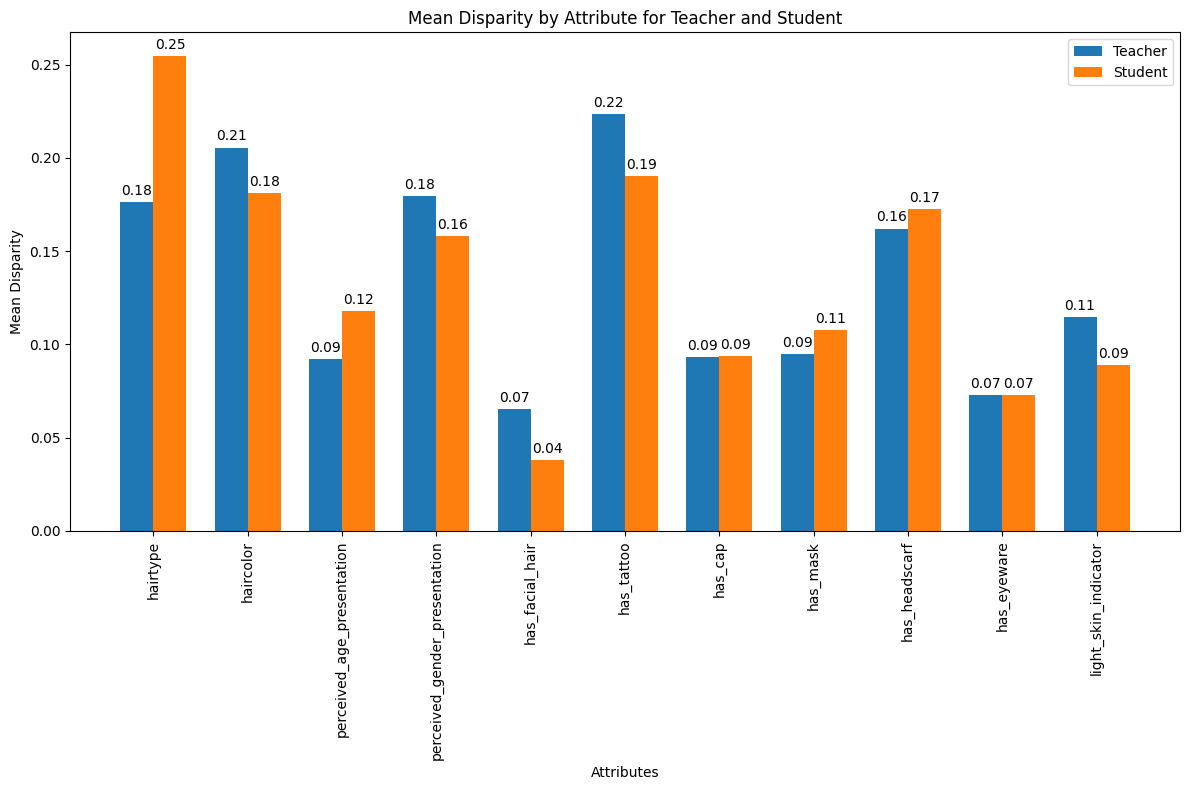

In [156]:
labels = teacher_mean_disparity_attribute_labels  # or student_mean_disparity_attribute_labels as they are the same
teacher_values = teacher_mean_disparity_attribute_values
student_values = student_mean_disparity_attribute_values

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
rects2 = ax.bar(x + width/2, student_values, width, label='Student')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Attributes')
ax.set_ylabel('Mean Disparity')
ax.set_title('Mean Disparity by Attribute for Teacher and Student')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


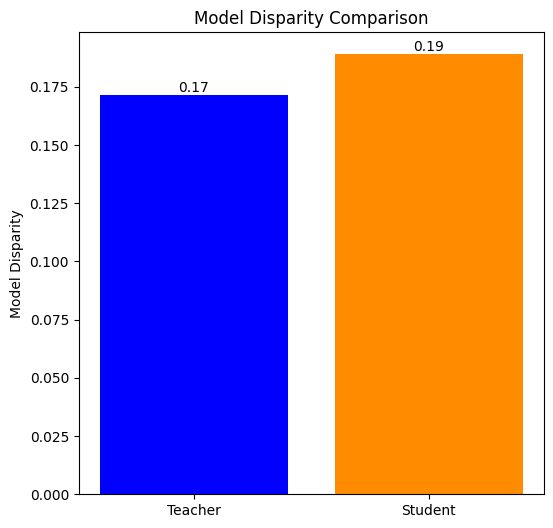

In [161]:
labels = ['Teacher', 'Student']
values = [teacher_overall_disparity, student_overall_disparity]

fig, ax = plt.subplots(figsize=(6, 6))
bars = ax.bar(labels, values, color=['blue', 'darkorange'])

ax.set_ylabel('Model Disparity')
ax.set_title('Model Disparity Comparison')

# Adding data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.show()
